In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Python packages

In [3]:
from collections import OrderedDict
import torch
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import random
import json
from optimizer.optimizer import BasePSOptimizer
import os

import configs
import utils
from generator.dataset import DataFolder
from optimizer.MOFinference import InferenceModel
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

Load Config and Data

In [4]:
config = configs.get_config()
utils.set_seed(config['generator_rand_seed'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = DataFolder(config['tensors_train_prop'], config['train_batch_size'])
test_dataset = DataFolder(config['tensors_test_prop'], config['train_batch_size'])

Load Model

In [5]:
inference_model = InferenceModel(config)
model = inference_model.model
model_y = inference_model.model_y
torch.set_grad_enabled(False)

In [6]:
pcn_700 = [('None', 'sym_8_mc_9', 'bcu', 'Cc1cc([Lr])ccc1c2c(C)cc([Lr])cc2')]
irmof_1 = [('None', 'sym_6_mc_3', 'pcu', '[Lr]c1ccc(cc1)[Lr]')]
pcn_700_tensor = inference_model.mof_building_to_mof_tensor(pcn_700)
pcn_700_z = inference_model.mof_tensor_to_mof_z(pcn_700_tensor)
irmof_1_tensor = inference_model.mof_building_to_mof_tensor(irmof_1)
irmof_1_z = inference_model.mof_tensor_to_mof_z(irmof_1_tensor)

Neighboring Space Sampling

In [7]:
mof_df = pd.DataFrame([('None', 'sym_8_mc_9', 'bcu', 'Cc1cc([Lr])ccc1c2c(C)cc([Lr])cc2', 0.0)], 
                      columns=['organic_core', 'metal_node', 'topology', 'branch_smiles', 'dist'])
i = 0
tries = 100
noise_max = 20
while i < tries:
    sample = []
    noise = random.uniform(0, noise_max)
    sample_z = utils.perturb_z(pcn_700_z.cpu(), noise)
    try:
        outs = inference_model.mof_z_to_mof_building(sample_z)
        smiles = outs[0][3]
        if utils.capacity_score_smiles(smiles):
            dist = np.linalg.norm(pcn_700_z.cpu() - sample_z)
            sample_df = pd.DataFrame([(outs[0][0], outs[0][1], outs[0][2], smiles, dist)],
                                        columns=['organic_core', 'metal_node', 'topology', 'branch_smiles', 'dist'])
            mof_df = pd.concat([mof_df, sample_df], axis=0)
            i = i + 1
    except:
        pass
mof_df = mof_df.sort_values(by=['dist']).reset_index(drop=True)
display(mof_df)

organic_core  metal_node topology  \
0             None  sym_8_mc_9      bcu   
1             None  sym_8_mc_9      bcu   
2             None  sym_8_mc_9      bcu   
3             None  sym_8_mc_9      bcu   
4             None  sym_8_mc_9      bcu   
..             ...         ...      ...   
96   sym_3_vae_337  sym_3_mc_0     srsb   
97            None  sym_7_mc_4      nia   
98   sym_5_vae_218  sym_5_mc_2      ssb   
99     sym_5_on_10  sym_5_mc_2     rhrb   
100  sym_4_vae_107  sym_4_mc_1     diab   

                                 branch_smiles       dist  
0             Cc1cc([Lr])ccc1c2c(C)cc([Lr])cc2   0.000000  
1           Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C   0.053042  
2           Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C   0.081852  
3           Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C   0.097639  
4           Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C   0.125316  
..                                         ...        ...  
96   CSCc1cc([Lr])c(O)cc1C#Cc1c(O)cc([Lr])cc1S  14.179162  
97              Nc1cc([Lr])cc([Lr])c1C(=O)OC=O  14.717999  
98     CCCc1c(C#C[Lr])ccc(CC(C#C[Lr])CCC)c1CCC  15.274826  
99      CCc1cc2cc3c([Lr])cccc3c(C)c2c([Lr])c1S  16.370382  
100          Cc1cccc([Lr])c1C(N)([Lr])c1ccccc1  16.693913  

[101 rows x 5 columns]

Interpolation Sampling

In [8]:
num_points = 20
chunks = torch.stack([
    torch.linspace(irmof_1_z[i, j], pcn_700_z[i, j], steps=num_points)
    for i in range(irmof_1_z.shape[0])
    for j in range(irmof_1_z.shape[1])
], dim=1).view(num_points, *irmof_1_z.shape)
mof_chunks = []
for chunk in chunks:
    outs = inference_model.mof_z_to_mof_building(chunk)
    mof_chunks.append(outs[0])
mof_df = pd.DataFrame(mof_chunks, columns=['organic_core', 'metal_node', 'topology', 'branch_smiles'])
display(mof_df)

organic_core  metal_node topology                       branch_smiles
0              None  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
1              None  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
2     sym_3_vae_561  sym_6_mc_3      pcu                  [Lr]c1ccc([Lr])cc1
3     sym_3_vae_561  sym_8_mc_8      pcu                  [Lr]c1ccc([Lr])cc1
4     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
5     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
6     sym_3_vae_561  sym_8_mc_8      the                  [Lr]c1ccc([Lr])cc1
7     sym_3_vae_561  sym_3_mc_0     srsb                  [Lr]c1ccc([Lr])cc1
8     sym_3_vae_561  sym_3_mc_0     srsb                  [Lr]c1ccc([Lr])cc1
9     sym_3_vae_561  sym_5_mc_2      pto      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
10  sym_3_vae_BR429  sym_5_mc_2      pto      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
11       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
12       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
13       sym_4_on_6  sym_5_mc_2      pth      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
14       sym_4_on_6  sym_5_mc_2      pts      Cc1cc([Lr])ccc1-c1ccc([Lr])cc1
15       sym_4_on_6  sym_5_mc_2      pts     Cc1cc([Lr])ccc1-c1ccc([Lr])cc1C
16       sym_4_on_6  sym_8_mc_8      pts  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
17             None  sym_8_mc_8      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
18             None  sym_8_mc_9      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C
19             None  sym_8_mc_9      bcu  Cc1cc([Lr])ccc1-c1c(C)cc([Lr])cc1C

PCA

In [9]:
img_title = ['PLD', 'LCD', 'density', 'AGSA', 'CO₂ uptake in CO₂/N₂',
            'N₂ uptake in CO₂/N₂', 'CO₂ uptake in CO₂/CH₄', 'CH₄ uptake in CO₂/CH₄']
y = []
z = []
for batch in tqdm(train_dataset):
    root_vecs, _, mol_batch = utils.get_vecs(model, batch, device)
    y.extend(model_y.scaler.inverse_transform(mol_batch['y'].cpu().numpy()))
    z.extend(root_vecs.cpu().numpy())
y = np.stack(y)
z = torch.tensor(np.stack(z))

  0%|          | 0/1000 [00:00<?, ?it/s]

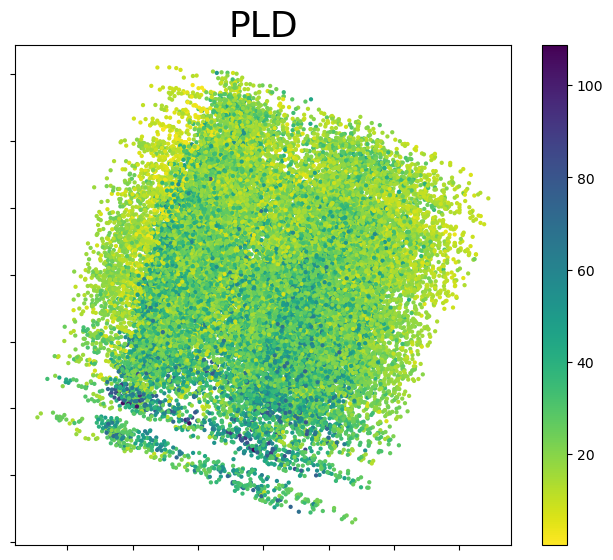

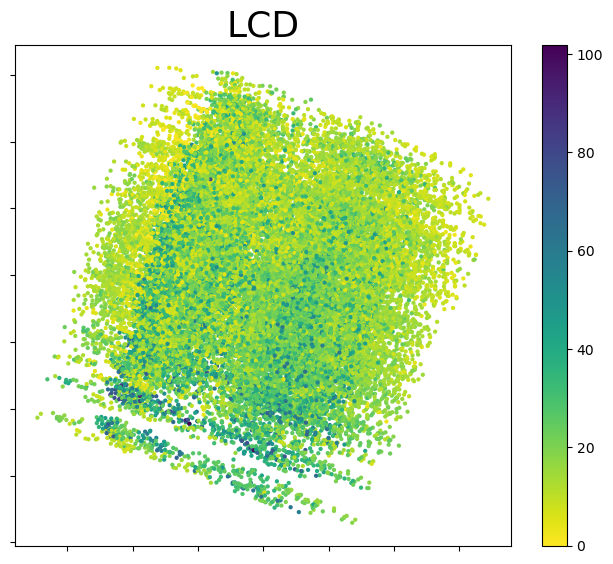

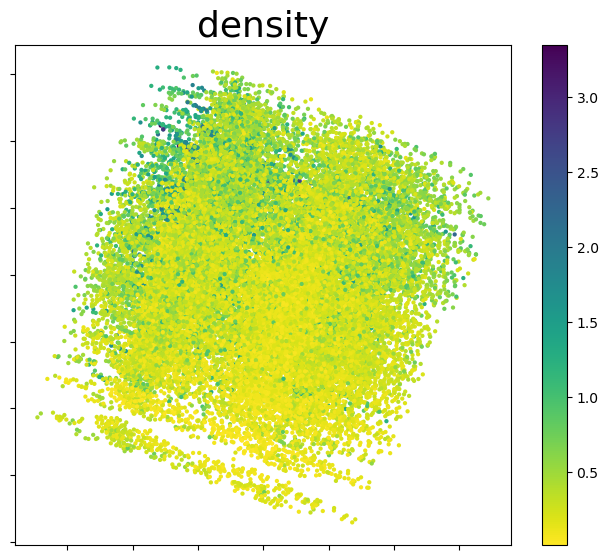

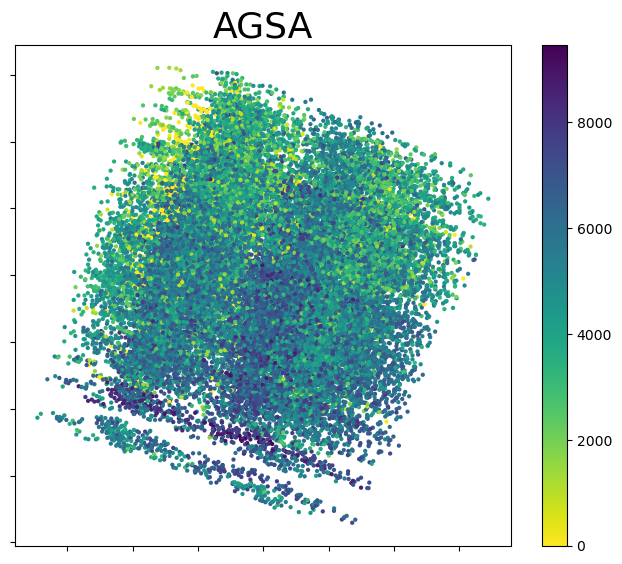

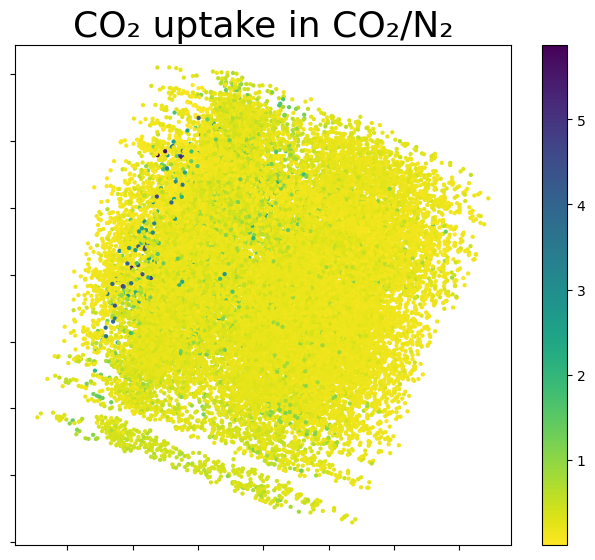

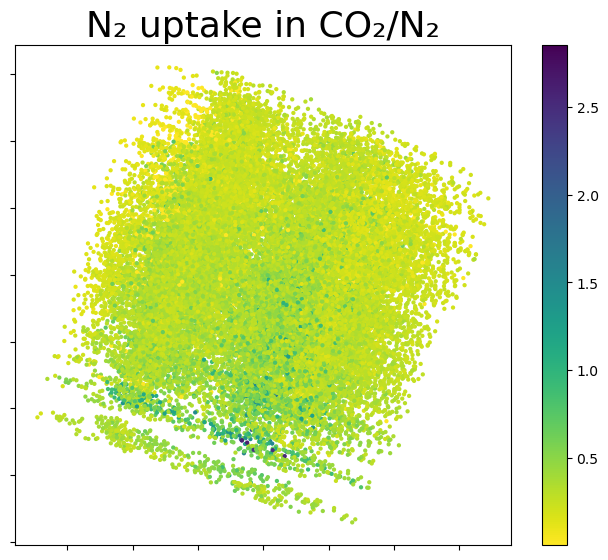

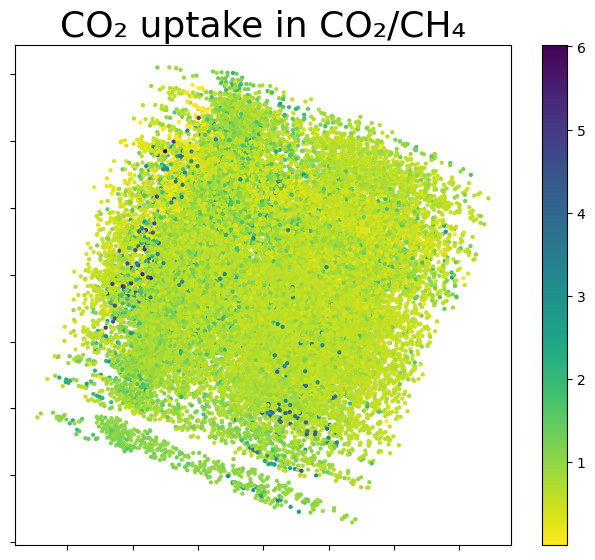

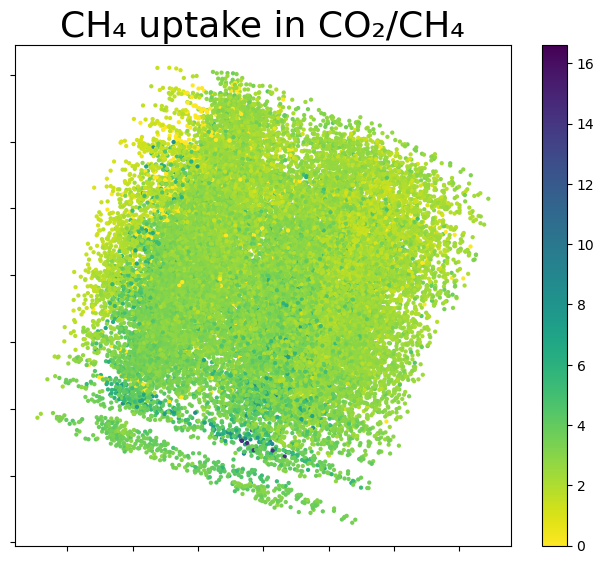

In [10]:
# U, S, V = torch.pca_lowrank(z,  q=2)
# data_pca = torch.matmul(z.cpu(), V)
z_centered = z - z.mean(dim=0)
U, S, V = torch.svd(z_centered)
V_q = V[:, :2]
data_pca = torch.mm(z_centered, V_q)
for index, y_label in enumerate(img_title):
    utils.pca_image(data_pca, y, index, y_label)

R2 of the Validation Set

In [11]:
y_true = OrderedDict()
y_pred = OrderedDict()
for i in range(len(config['col_y'])):
    y_true[i] = []
    y_pred[i] = []
for batch in tqdm(test_dataset):
    root_vecs, tree_vecs, mol_batch = utils.get_vecs(model, batch, device)
    outputs = model_y.z_to_y(root_vecs, tree_vecs)
    y_true_scaler = model_y.scaler.inverse_transform(mol_batch['y'].cpu().numpy())
    for i in range(len(config['col_y'])):
        y_true[i].extend(y_true_scaler[:, i].reshape(-1))
        y_pred[i].extend(outputs[:, i].reshape(-1))
r2_results = utils.regression_statistics(y_true, y_pred, config['col_y'])

  0%|          | 0/1000 [00:00<?, ?it/s]

lcd : R2 =  0.9255340183521433 , MAE =  2.1927084825830176 , RMSE =  3.6586267669623895
pld : R2 =  0.9194142224401364 , MAE =  1.9730736566182199 , RMSE =  3.4677818569579104
density : R2 =  0.9237848162709537 , MAE =  0.04015600674270978 , RMSE =  0.0778349898092804
agsa : R2 =  0.9258702756396011 , MAE =  307.7914144443089 , RMSE =  482.8822069807676
co2n2_co2_mol_kg : R2 =  0.8119149982297506 , MAE =  0.04316284284148402 , RMSE =  0.11100352856995795
co2n2_n2_mol_kg : R2 =  0.9336240829464032 , MAE =  0.02297976550246795 , RMSE =  0.0404637781102559
co2ch4_co2_mol_kg : R2 =  0.872400272383532 , MAE =  0.07225984974296484 , RMSE =  0.15689719961171383
co2ch4_ch4_mol_kg : R2 =  0.8833998372784186 , MAE =  0.1846360523856334 , RMSE =  0.3157667475462152


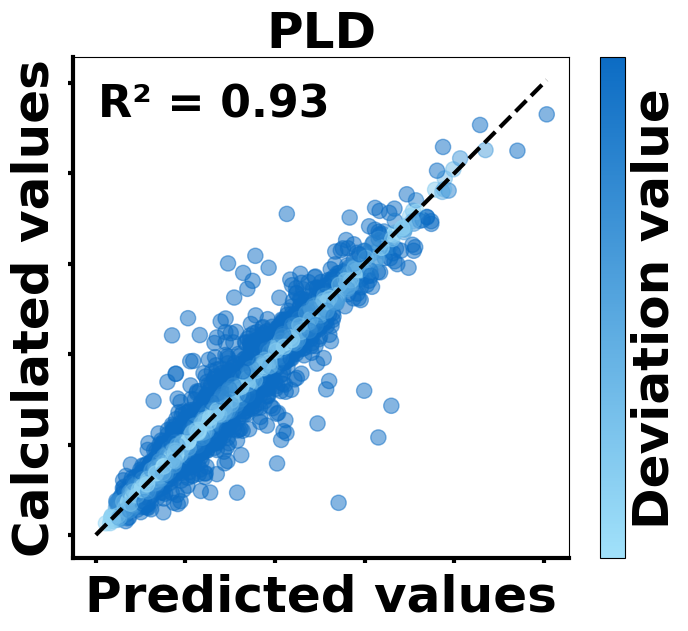

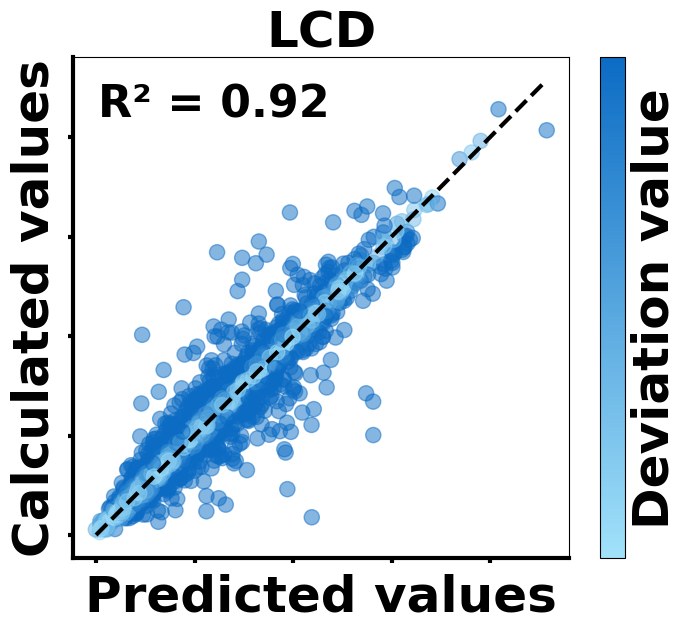

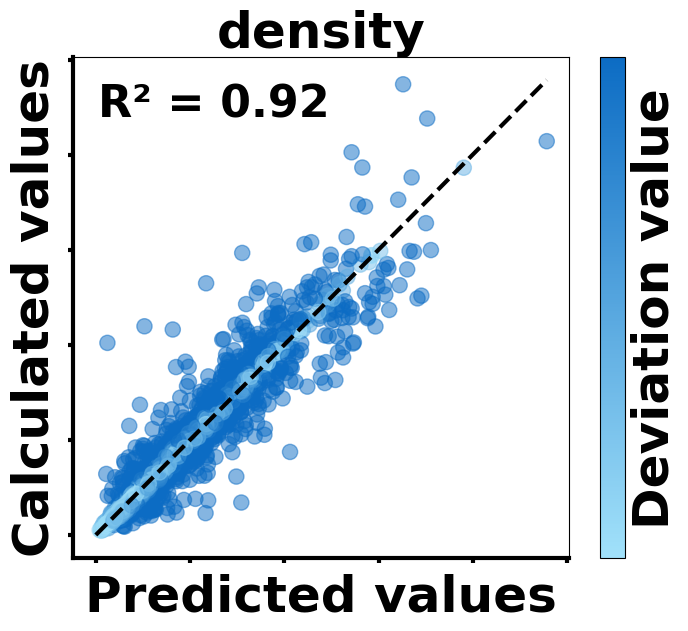

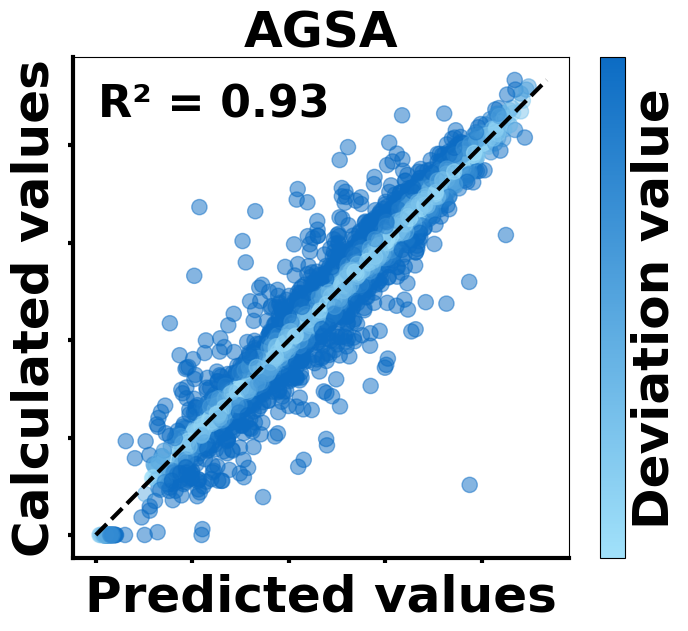

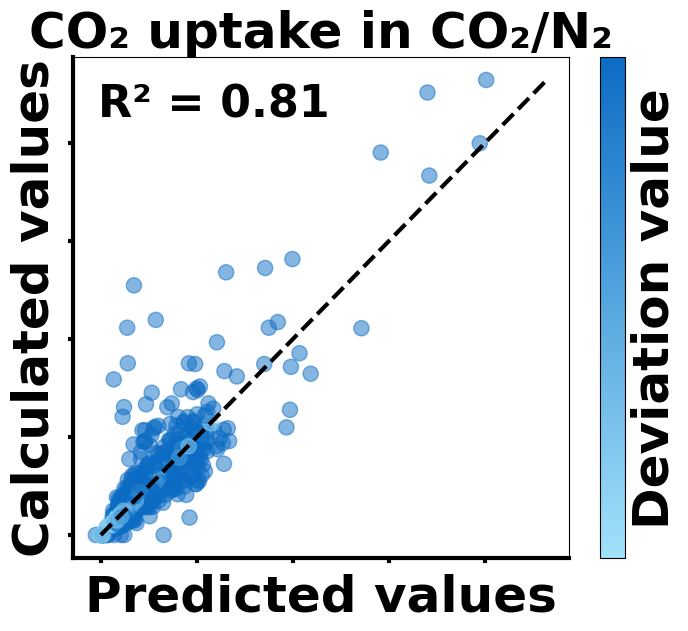

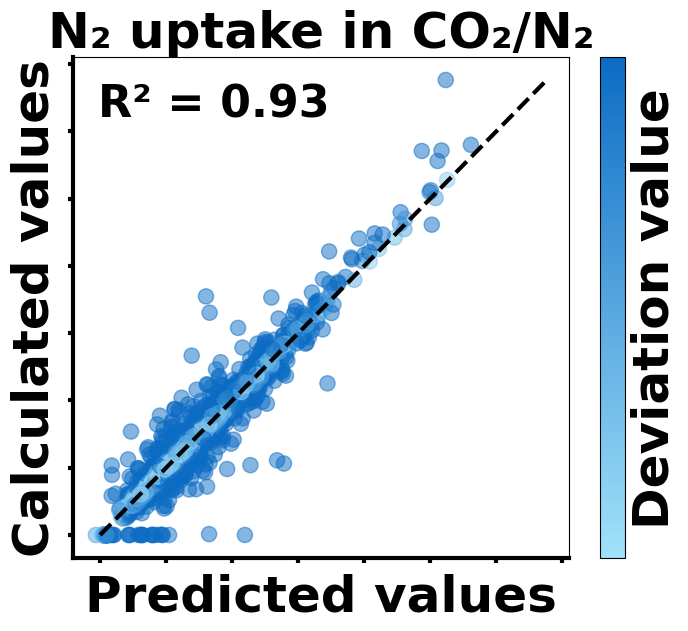

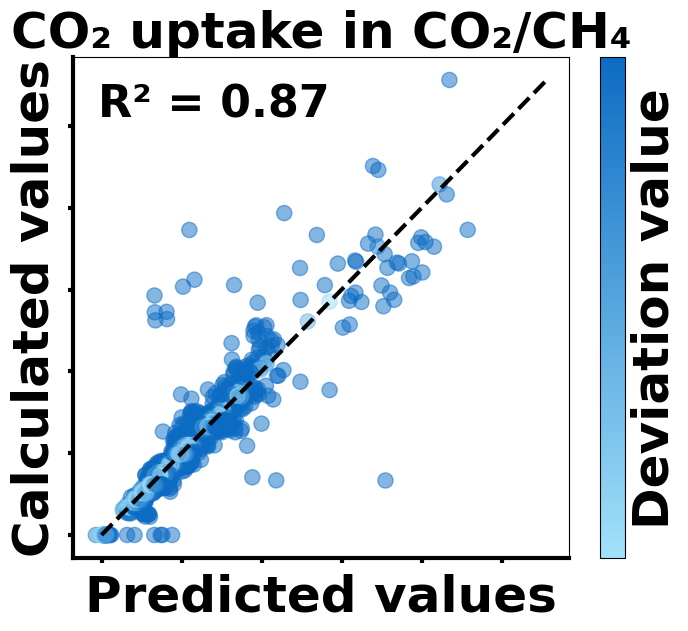

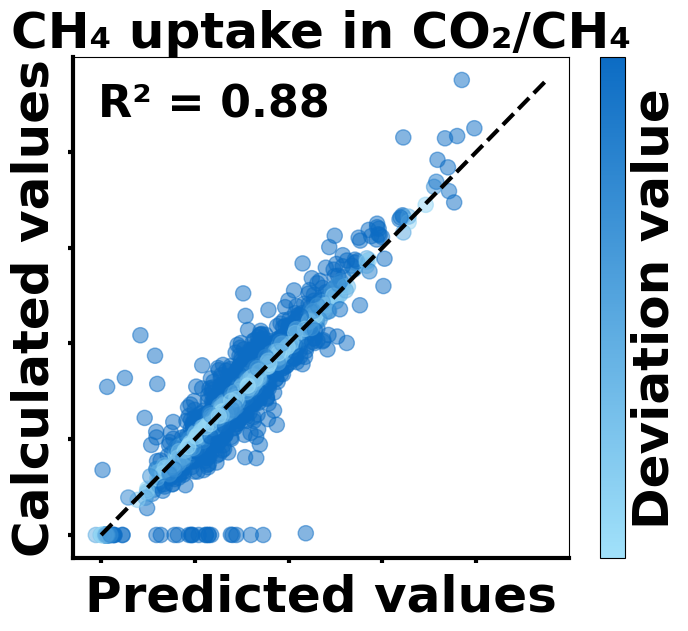

In [12]:
for index, r2_title_value in enumerate(img_title):
    r2 = r2_results['R2'][index]
    y_true_values = y_true[index]
    y_pred_values = y_pred[index]
    plt = utils.plot_scatter_with_deviation(y_true_values, y_pred_values, r2, r2_title_value)
    plt.show()

Find Candidates

In [13]:
start_mof = [('None', 'sym_6_mc_3', 'pcu', '[Lr]c1ccc(cc1)[Lr]')]

if not os.path.exists(config['x_max']) or not config['x_min']:
    model = inference_model.model
    train_dataset = DataFolder(config['tensors_train_prop'], config['train_batch_size'])
    z = []
    x_max = []
    x_min = []
    with torch.no_grad():
        for batch in tqdm(train_dataset):
            root_vecs, _, _ = utils.get_vecs(model, batch, device)
            z.extend(root_vecs.cpu().numpy())
    z = np.stack(z)
    for index in range(z.shape[1]):
        x_max.append(np.max(z[:, index]))
        x_min.append(np.min(z[:, index]))
    np.save(config['x_max'], x_max)
    np.save(config['x_min'], x_min)
else:
    x_max = np.load(config['x_max'])
    x_min = np.load(config['x_min'])

opt_config_dict = dict(configs.opt_config())
print("optimizer config: ")
print(json.dumps(opt_config_dict, indent=4))

optimizer config: 
{
    "opt_num_part": 10,
    "opt_num_swarms": 1,
    "opt_iterations_num": 50,
    "opt_num_track": 20,
    "opt_fitness_name": "co2n2_co2_mol_kg",
    "opt_col": [
        "fitness",
        "branch_smiles",
        "metal_node",
        "organic_core",
        "topology",
        "lcd",
        "pld",
        "density",
        "agsa",
        "co2n2_co2_mol_kg",
        "co2n2_n2_mol_kg",
        "co2ch4_co2_mol_kg",
        "co2ch4_ch4_mol_kg"
    ],
    "x_min": "results/z_max_min/x_min.npy",
    "x_max": "results/z_max_min/x_max.npy",
    "v_min": -0.4,
    "v_max": 0.4
}


In [14]:
opt = BasePSOptimizer.from_query(
        init_building_list=start_mof,
        num_part=config['opt_num_part'],
        num_swarms=config['opt_num_swarms'],
        inference_model=inference_model,
        fitness_name=config['opt_fitness_name'],
        opt_col=config['opt_col'],
        x_min=x_min,
        x_max=x_max,
        v_min=config['v_min'],
        v_max=config['v_max'],
)
opt.run(config['opt_iterations_num'], num_track=config['opt_num_track'])
display(opt.step_fitness_history)

step  max_fitness  min_fitness  mean_fitness
0     0     0.472516     0.472516      0.472516
0     1     1.151540     0.472516      0.531627
0     2     1.202544     0.499402      0.778418
0     3     1.438548     0.499402      0.919360
0     4     1.438548     0.629207      0.974612
0     5     1.503847     0.689863      1.065431
0     6     2.648363     0.689863      1.163356
0     7     2.648363     0.900531      1.274886
0     8     2.648363     0.900531      1.274886
0     9     2.648363     0.900531      1.274886
0    10     2.648363     0.928199      1.278956
0    11     2.648363     0.928199      1.278956
0    12     2.648363     0.928199      1.278956
0    13     2.648363     0.928199      1.278956
0    14     2.648363     0.928199      1.278956
0    15     2.648363     0.928199      1.278956
0    16     2.648363     0.985141      1.349178
0    17     2.648363     0.990867      1.370555
0    18     2.648363     0.990867      1.370555
0    19     2.648363     0.990867      1.370555
0    20     2.648363     0.990867      1.370555
0    21     2.648363     0.990867      1.370555
0    22     2.648363     0.990867      1.370555
0    23     2.648363     0.990867      1.370555
0    24     2.648363     0.990867      1.370555
0    25     2.648363     1.151540      1.424125
0    26     2.648363     1.151540      1.424125
0    27     2.648363     1.151540      1.444665
0    28     2.648363     1.151540      1.444665
0    29     2.648363     1.151540      1.452035
0    30     2.648363     1.151540      1.452035
0    31     2.648363     1.151540      1.452035
0    32     2.648363     1.151540      1.452035
0    33     2.648363     1.151540      1.453135
0    34     2.648363     1.151540      1.455858
0    35     2.648363     1.151540      1.455858
0    36     2.648363     1.151540      1.455858
0    37     2.648363     1.151540      1.470781
0    38     2.648363     1.151540      1.470781
0    39     2.648363     1.151540      1.470781
0    40     2.648363     1.151540      1.470781
0    41     2.648363     1.151540      1.470781
0    42     2.648363     1.157143      1.475887
0    43     2.648363     1.202544      1.488483
0    44     2.648363     1.202544      1.488483
0    45     2.648363     1.202544      1.502338
0    46     2.648363     1.202544      1.502338
0    47     2.648363     1.202544      1.502338
0    48     2.648363     1.202544      1.502338
0    49     2.648363     1.202544      1.502338

In [15]:
display(opt.best_step_mof_history)

fitness    organic_core    metal_node topology  \
0   0.472516            None    sym_6_mc_3      pcu   
1   0.472516            None    sym_6_mc_3      pcu   
2   1.151540            None    sym_6_mc_3      bcs   
3   1.202544            None    sym_6_mc_3      bcs   
4   1.438548            None    sym_6_mc_3      bcs   
5   0.990867     sym_16_mc_6    sym_4_mc_1      bcs   
6   1.503847     sym_16_mc_6  sym_24_mc_13      bcs   
7   2.648363     sym_16_mc_6    sym_4_mc_1      bcs   
8   1.666426     sym_16_mc_6    sym_4_mc_1      bcs   
9   0.521632     sym_16_mc_6    sym_4_mc_1      bcs   
10  0.821981            None  sym_24_mc_13      bcs   
11  0.981930            None    sym_6_mc_3      bcs   
12  0.501467            None    sym_6_mc_3      bcs   
13  0.368935   sym_3_vae_210  sym_24_mc_13      bcs   
14  0.872211     sym_16_mc_6    sym_4_mc_1      bcs   
15  0.385406            None  sym_24_mc_13      bcs   
16  0.743402            None  sym_24_mc_13      bcs   
17  1.904313     sym_16_mc_6    sym_4_mc_1      bcs   
18  1.412679     sym_16_mc_6  sym_24_mc_13      bcs   
19  0.682863            None    sym_6_mc_3      bcs   
20  0.816431     sym_16_mc_6    sym_4_mc_1      bcs   
21  0.938320    sym_3_vae_45  sym_24_mc_13      bcs   
22  0.946616     sym_16_mc_6  sym_24_mc_13      bcs   
23  0.441820     sym_16_mc_6    sym_4_mc_1      bcs   
24  0.375471    sym_3_vae_45    sym_8_mc_9      the   
25  0.416288   sym_3_vae_165  sym_24_mc_13      rht   
26  1.833179     sym_16_mc_6    sym_4_mc_1      bcs   
27  0.328582  sym_3_vae_2082    sym_8_mc_9      bcs   
28  1.562346     sym_16_mc_6    sym_4_mc_1      bcs   
29  0.687990     sym_16_mc_6    sym_4_mc_1      bcs   
30  1.298928     sym_16_mc_6    sym_4_mc_1      bcs   
31  0.429855  sym_5_vae_1526    sym_4_mc_1      bor   
32  0.386639            None    sym_6_mc_3      bcs   
33  0.208505   sym_3_vae_403  sym_24_mc_13      rht   
34  1.173555   sym_3_vae_403  sym_24_mc_13      bcs   
35  1.206005            None  sym_24_mc_13      bcs   
36  0.527092   sym_3_vae_724    sym_4_mc_1      bcs   
37  0.364958   sym_3_vae_403  sym_24_mc_13      bcs   
38  1.449991     sym_16_mc_6    sym_4_mc_1      bcs   
39  0.361332     sym_16_mc_6    sym_4_mc_1      bcs   
40  0.624117   sym_3_vae_724  sym_24_mc_13      bcs   
41  0.724489      sym_3_on_1    sym_4_mc_1     srsb   
42  0.564817            None    sym_6_mc_3      bcs   
43  1.253657     sym_16_mc_6  sym_24_mc_13      bcs   
44  1.369553     sym_16_mc_6    sym_4_mc_1      bcs   
45  0.930214     sym_16_mc_6    sym_4_mc_1      bcs   
46  1.479640            None  sym_24_mc_13      bcs   
47  0.861852     sym_16_mc_6  sym_24_mc_13      bcs   
48  0.264340  sym_3_vae_1001    sym_8_mc_8      pyr   
49  0.573722     sym_16_mc_6    sym_4_mc_1      bcs   
50  0.661434   sym_3_vae_403  sym_24_mc_13      bcs   

                                        branch_smiles        lcd        pld  \
0                                  [Lr]c1ccc(cc1)[Lr]   9.109508   6.049568   
1                                  [Lr]c1ccc([Lr])cc1   9.109509   6.049571   
2                                  [Lr]c1ccc([Lr])cc1   9.068007   6.372395   
3                            [Lr]c1ccc([Lr])c2ccccc12   9.405013   6.467889   
4                            [Lr]c1ccc([Lr])c2ccccc12   8.485383   5.096816   
5                     Cc1cc(Cc2c(C)cccc2[Lr])ccc1[Lr]   8.877563   5.213698   
6                        Cc1cc([Lr])ccc1-c1ccccc1[Lr]   8.778188   4.466678   
7                        Cc1cc([Lr])ccc1-c1ccccc1[Lr]   7.608458   3.588648   
8                     CC1=CC([Lr])CC(c2ccccc2[Lr])=C1   9.425893   5.431906   
9                     CC1=C(c2cccc([Lr])c2)C([Lr])=C1  10.981445   6.501033   
10                     Cc1cc([Lr])c(-c2ccccc2)cc1[Lr]   8.828374   5.657339   
11                                 [Lr]c1ccc([Lr])cc1   8.228459   5.805273   
12                                 [Lr]c1cccc([Lr])c1  11.709714   9.369858   
13         Cc1ccc([Lr])c(-c2cc([Lr])cc